In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# 1h three lines bullish, buy at 4h ema 38, out at bb_u, or (red vol > previous green, and red low < previous green open)
# additional, atr, buy 1 position only

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import os

In [4]:
from binance.client import Client
from dotenv import load_dotenv

# Get the path to the current directory
current_directory = os.getcwd()

# Specify the path to the .env file relative to the current directory
dotenv_path = os.path.join(current_directory, '.env')

# Load the environment variables from the .env file
load_dotenv(dotenv_path)

api_key = os.getenv('API_KEY')
api_secret = os.getenv('SECRET_KEY')

client = Client(api_key, api_secret, testnet = False)

In [5]:
timezone = 8
symbol = 'ethusdt'
interval = '1h'


start_time = 1635743450000
end_time = round(time.time() * 1000)

def def_time():
    global start_time, end_time
    start_time = 1635743450000
    end_time = round(time.time() * 1000)
    # end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [6]:
dataframes = {}
# 先抓歷史資料好讓技術指標能成型
def create_raw(symbol, interval_arr, step):
    global start_time, end_time
    # Fetch the data using batch requests
    for interval in interval_arr:
        def_time()
        data = []    
        while start_time < end_time:
            
            limit = min(step, end_time - start_time + 1)  # Adjust the limit for the last batch
            response = client.get_klines(symbol=symbol.upper(), interval=interval, limit=limit, startTime=start_time)

            if len(response) == 0:
                break  # No more data available, exit the loop
            data.extend(response)
            start_time = response[-1][0] + 1

            # Convert the data to a DataFrame
        columns = [
            "Open_Time", "Open", "High", "Low", "Close", "Volume", "Close_Time",
            "Quote asset volume", "Number of trades", "Taker buy base asset volume",
            "Taker buy quote asset volume", "Ignore"
        ]
        raw_df = pd.DataFrame(data, columns=columns)   

        raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]

        dataframes[f'df_{interval}'] = raw_df

In [7]:
interval_arr = ['1h', '4h']
start_time_arr = [1609492611000]
ema_arr = [8, 18, 38]

In [8]:
ep_per = 0.997
sl_per = 1.02
sl_atr = 2
tp_atr = 10
rsi_int = 14
kd_dir = 'Up'
rsi_high = 70

In [9]:
def get_klines(symbol, interval):
    global dataframes
    df = dataframes[f'df_{interval}']
    df = df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Open_Time')

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
loop_start_time = time.time()
raw_df = create_raw(symbol, interval_arr, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
print(raw_df)
print(dataframes)

Time taken to execute for loop: 14.857348442077637 seconds
None
{'df_1h':            Open_Time           Open          Close           High  \
0      1635746400000  4225.00000000  4241.99000000  4259.14000000   
1      1635750000000  4241.99000000  4302.93000000  4320.00000000   
2      1635753600000  4302.94000000  4311.11000000  4338.07000000   
3      1635757200000  4311.11000000  4316.56000000  4344.41000000   
4      1635760800000  4316.55000000  4328.94000000  4335.00000000   
...              ...            ...            ...            ...   
14940  1689534000000  1930.99000000  1927.78000000  1933.09000000   
14941  1689537600000  1927.79000000  1928.59000000  1931.18000000   
14942  1689541200000  1928.60000000  1930.44000000  1931.16000000   
14943  1689544800000  1930.43000000  1933.39000000  1937.20000000   
14944  1689548400000  1933.38000000  1918.70000000  1934.20000000   

                 Low          Volume  
0      4198.55000000  13908.93710000  
1      4241.4600000

In [11]:
df = get_klines(symbol, interval_arr[0]).copy()
df = df.astype(float).round(4)

for interval in interval_arr:
    raw_df = get_klines(symbol, interval)
    # ema
    for ema in ema_arr:
        column_name = f'ema_{ema}_{interval}'
        df[column_name] = ta.trend.EMAIndicator(raw_df.Close, window=ema, fillna=True).ema_indicator()

    # rsi
#     rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
#     df[f'rsi_{interval}'] = rsi.rsi()

    # atr
#         df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)


# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# fill up higher time frame empty values with equal interval between each value
df = df.replace('', np.nan)
df['ema_8_4h'] = df['ema_8_4h'].interpolate()
df['ema_18_4h'] = df['ema_18_4h'].interpolate()
df['ema_38_4h'] = df['ema_38_4h'].interpolate()
# df['rsi_4h'] = df['rsi_4h'].interpolate()

In [12]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    df['slow_k']= ta.momentum.stoch(df['High'], df['Low'], df['Close'], 17, 5)
    df['slow_d'] = ta.momentum.stoch_signal(df['High'], df['Low'], df['Close'], 17, 5)
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [13]:
indicators(df, kd_dir)
print(df)

                 Open_Time     Open    Close     High      Low      Volume  \
0      2021-11-01 14:00:00  4225.00  4241.99  4259.14  4198.55  13908.9371   
1      2021-11-01 15:00:00  4241.99  4302.93  4320.00  4241.46  31363.2190   
2      2021-11-01 16:00:00  4302.94  4311.11  4338.07  4294.52  21038.5542   
3      2021-11-01 17:00:00  4311.11  4316.56  4344.41  4310.64  16175.3592   
4      2021-11-01 18:00:00  4316.55  4328.94  4335.00  4313.86  11207.7111   
...                    ...      ...      ...      ...      ...         ...   
14940  2023-07-17 03:00:00  1930.99  1927.78  1933.09  1925.79   6035.6596   
14941  2023-07-17 04:00:00  1927.79  1928.59  1931.18  1926.79   4114.4528   
14942  2023-07-17 05:00:00  1928.60  1930.44  1931.16  1928.07   2740.3451   
14943  2023-07-17 06:00:00  1930.43  1933.39  1937.20  1928.78   5992.6124   
14944  2023-07-17 07:00:00  1933.38  1918.70  1934.20  1916.73  10881.6264   

          ema_8_1h    ema_18_1h    ema_38_1h     ema_8_4h    em

In [14]:
def conditions(df):

    df['c1'] = df['ema_8_1h'] <= df['ema_18_1h']
    df['c2'] = df['ema_18_1h'] <= df['ema_38_1h']
    df['c3'] = df['ema_8_4h'] <= df['ema_18_4h']
    # c5
#     df['c5'] = False
#     for i, row in df.iterrows():

#         if i >= 14:
#             if (df.loc[i-14:i-1, 'rsi_4h'] <= rsi_high).any():
#                 df.loc[i, 'c5'] = True

    # 條件達成
    df['signal'] = df.c1 & df.c2 & df.c3


    # 下一根進場
    df['open_entry'] = df['signal'] & (df['High'] >= df['ema_18_4h'] * ep_per)
    
    return df

In [15]:
conditions(df)

,Open_Time,Open,Close,High,Low,Volume,ema_8_1h,ema_18_1h,ema_38_1h,ema_8_4h,...,bb_l,atr,slow_k,slow_d,kd_cross,c1,c2,c3,signal,open_entry
0,2021-11-01 14:00:00,4225.00,4241.99,4259.14,4198.55,13908.9371,4241.990000,4241.990000,4241.990000,NaN,...,NaN,0.000000,NaN,NaN,False,True,True,False,False,False
1,2021-11-01 15:00:00,4241.99,4302.93,4320.00,4241.46,31363.2190,4255.532222,4248.404737,4245.115128,NaN,...,NaN,0.000000,NaN,NaN,False,False,False,False,False,False
2,2021-11-01 16:00:00,4302.94,4311.11,4338.07,4294.52,21038.5542,4267.882840,4255.005291,4248.499481,4315.000000,...,NaN,0.000000,NaN,NaN,False,False,False,True,False,False
3,2021-11-01 17:00:00,4311.11,4316.56,4344.41,4310.64,16175.3592,4278.699986,4261.484734,4251.989764,4316.943333,...,NaN,0.000000,NaN,NaN,False,False,False,False,False,False
4,2021-11-01 18:00:00,4316.55,4328.94,4335.00,4313.86,11207.7111,4289.864434,4268.585288,4255.935930,4318.886667,...,NaN,0.000000,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14940,2023-07-17 03:00:00,1930.99,1927.78,1933.09,1925.79,6035.6596,1932.469715,1932.208992,1934.199962,1930.329116,...,1923.356009,6.738933,31.255449,63.956674,False,False,True,True,False,False
14941,2023-07-17 04:00:00,1927.79,1928.59,1931.18,1926.79,4114.4528,1931.607556,1931.828045,1933.912271,1929.553842,...,1923.193228,6.571152,34.786399,55.475713,False,True,True,True,True,True
14942,2023-07-17 05:00:00,1928.60,1930.44,1931.16,1928.07,2740.3451,1931.348099,1931.681935,1933.734206,1929.553842,...,1923.171859,6.322498,42.850915,49.081429,False,True,True,True,True,True
14943,2023-07-17 06:00:00,1930.43,1933.39,1937.20,1928.78,5992.6124,1931.801855,1931.861731,1933.716555,1929.553842,...,1923.171479,6.472320,55.710549,44.426585,True,True,True,True,True,True


In [16]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
open_val = entry_df['Open']
high_val = entry_df['High']
atr_val = entry_df['atr']
ema_18_val = entry_df['ema_18_4h']
vol_val = entry_df['Volume']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = ema_18_val.at[index] * ep_per
        entry_df.at[index, 'stop_loss'] = high_val.at[index] * sl_per
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position and row['Close'] >= stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position and row['Low'] <= row['bb_l']:
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
    elif in_position and (((vol_val.at[index] > vol_val.shift(1).at[index]) & # vol greater
                          (open_val.shift(1).at[index] > close_val.shift(1).at[index]) & # previous red candle
                          (open_val.at[index] < close_val.at[index]) & # current green candle
                          (high_val.at[index] > open_val.shift(1).at[index])) or # current high > previous red open
                          (high_val.at[index] >= stop_loss)): # current high > previous open
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan    
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry']) | (entry_df['position'] != '')]

print(entry_df)

                 Open_Time     Open    Close     High      Low      Volume  \
0      2021-11-01 14:00:00  4225.00  4241.99  4259.14  4198.55  13908.9371   
1      2021-11-01 15:00:00  4241.99  4302.93  4320.00  4241.46  31363.2190   
2      2021-11-01 16:00:00  4302.94  4311.11  4338.07  4294.52  21038.5542   
3      2021-11-01 17:00:00  4311.11  4316.56  4344.41  4310.64  16175.3592   
4      2021-11-01 18:00:00  4316.55  4328.94  4335.00  4313.86  11207.7111   
...                    ...      ...      ...      ...      ...         ...   
14940  2023-07-17 03:00:00  1930.99  1927.78  1933.09  1925.79   6035.6596   
14941  2023-07-17 04:00:00  1927.79  1928.59  1931.18  1926.79   4114.4528   
14942  2023-07-17 05:00:00  1928.60  1930.44  1931.16  1928.07   2740.3451   
14943  2023-07-17 06:00:00  1930.43  1933.39  1937.20  1928.78   5992.6124   
14944  2023-07-17 07:00:00  1933.38  1918.70  1934.20  1916.73  10881.6264   

          ema_8_1h    ema_18_1h    ema_38_1h     ema_8_4h  ... 

In [17]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位 usdt
pos_size = 200

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'bb_u', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size / pos.at[index, 'entry_p']
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場

        if pos.at[index, 'position'] == 'Buy':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            
        # 停利：達成條件時收盤價
#         if (pos.at[index, 'position'] == 'Sell') & (pos.at[index, 'High'] >= pos.at[index, 'bb_u']) :
#             pos.at[index, 'exit_p'] = pos.at[index, 'bb_u']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
#                 break


        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Buy']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] - np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Buy']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt -= trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()

# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Short':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Buy', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if position_amt_sum > max_profit:
            max_profit = position_amt_sum
            
        if position_amt_sum < max_loss:
            max_loss = position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade > 0:
        wins += 1
    elif trade < 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

max_drawdown = min(cumulative_values)
    
# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate],
          'Max_Drawdown': [round(max_drawdown,2)]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit    Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  691.98  64.82       47.42    -19.44         10        2000.0  345.99%   

  Win_Rate  Max_Drawdown  
0   67.31%         37.32  

               Open_Time     Open    Close     High      Low         bb_u  \
0    2021-11-06 03:00:00  4500.88  4495.00  4501.52  4475.74  4557.589672   
1    2021-11-06 04:00:00  4495.00  4448.65  4496.58  4438.80  4556.968939   
2    2021-11-06 08:00:00  4474.24  4498.86  4507.29  4455.88  4552.973647   
3    2021-11-06 09:00:00  4498.86  4497.42  4511.70  4477.69  4553.059873   
4    2021-11-06 10:00:00  4497.42  4482.55  4504.76  4473.15  4552.441798   
..                   ...      ...      ...      ...      ...          ...   
477  2023-07-13 12:00:00  1867.40  1865.98  1869.46  1864.27  1896.886952   
478  2023-07-13 15:00:00  1872.77  1870.36  1874.50  1870.18  1897.143892   
479  2023-07-13 16:00:00  1870.37  1873.40  1874.26  1869.86  1896.932036   
480  2023-07-16 15:00:

In [18]:
plt_df = pos[['Open_Time', 'position', 'amt']]

cumulative_sum = 0
agg_amts = []
stop_date = None

for index, row in plt_df.iterrows():
    if row['position'] == 'Short':
        cumulative_sum += row['amt']
    elif row['position'] == 'Stop' or row['position'] == 'Buy':
        cumulative_sum += row['amt']
        stop_date = row['Open_Time']
        agg_amts.append((stop_date, cumulative_sum))
        cumulative_sum = 0

        
# Convert the list of tuples into a new dataframe
agg_df = pd.DataFrame(agg_amts, columns=['date', 'cumulative_sum'])
# agg_df['cumulative_sum'] = agg_df['cumulative_sum'].apply(lambda x: -x)

print(agg_df['cumulative_sum'].sum())
print(agg_df)

756.7993000000001
                    date  cumulative_sum
0    2021-11-06 18:00:00         42.7894
1    2021-11-07 14:00:00         -3.2911
2    2021-11-13 14:00:00          6.2843
3    2021-11-14 07:00:00          0.8657
4    2021-11-14 16:00:00          2.7455
..                   ...             ...
151  2023-07-10 13:00:00          1.3324
152  2023-07-11 02:00:00         -4.6269
153  2023-07-13 12:00:00          1.6971
154  2023-07-13 16:00:00          0.0799
155  2023-07-16 22:00:00         -0.9277

[156 rows x 2 columns]


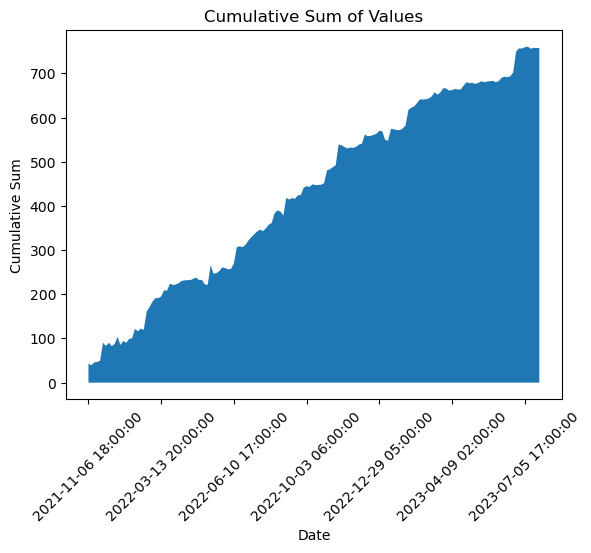

37.318049150000135


In [19]:
cumulative_values = []
cumulative_sum = 0
for value in agg_df['cumulative_sum']:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(agg_df['date'], cumulative_values, 0)

plt.xlabel('Date')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')


n = 25  # Adjust the value of n as per your preference
plt.xticks(agg_df['date'][::n], rotation=45)
plt.show()

print(max_drawdown)
# print(cumulative_values)

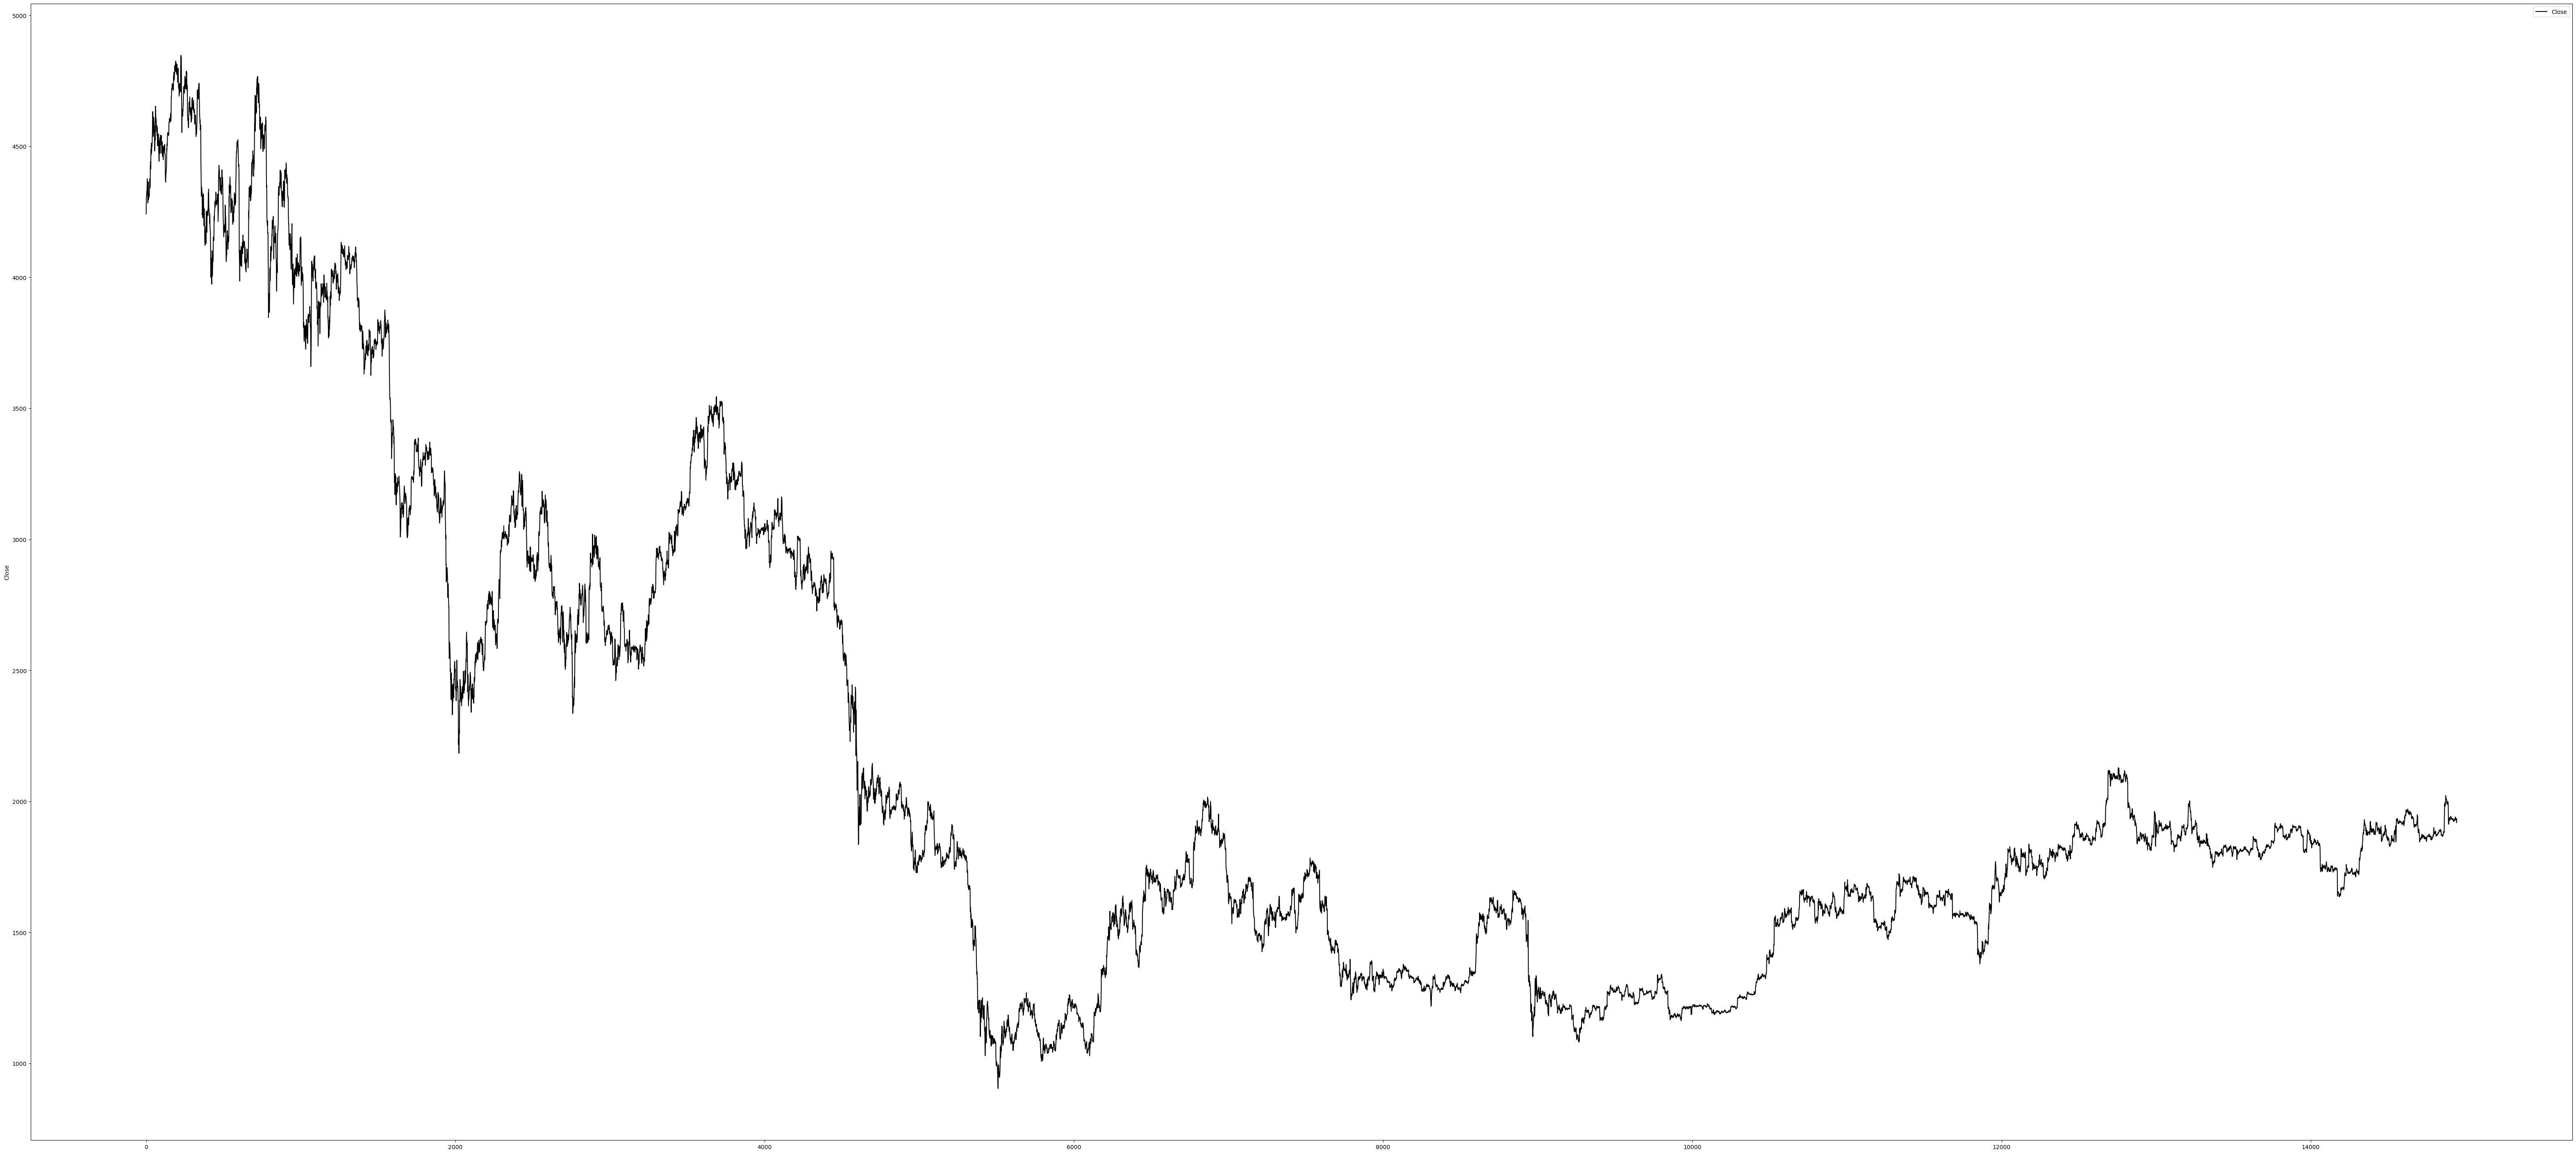

In [20]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位